In [8]:
#0. Setup
import yfinance as yf
import pandas as pd
import numpy as np
!pip install pytorch-lightning
!pip install pmdarima
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 11.4 MB/s eta 0:00:00


In [44]:
# 1. Download data
import yfinance as yf
import pandas as pd
import numpy as np

df = yf.download("AAPL", start="2020-01-01", end="2025-01-01")

# Flatten the MultiIndex columns to single-level columns
# This assumes there's only one ticker (AAPL)
df.columns = df.columns.droplevel(level=1)

# Ensure the index is a DatetimeIndex and set its frequency to business daily
df.index = pd.to_datetime(df.index)
df = df.asfreq('B')

# Rename 'Close' to 'Price' AFTER flattening columns
df = df.rename(columns={'Close':'Price'})

# Fill NaNs in 'Price' column introduced by asfreq('B') or initial data
df['Price'] = df['Price'].ffill()

#2a. Rolling prices
df['Price_3'] = df['Price'].rolling(window=3).mean()
df['Price_10'] = df['Price'].rolling(window=10).mean()
df['Price_100'] = df['Price'].rolling(window=100).mean()

#2b. Rolling volaility
df['Returns'] = df['Price'].pct_change()
df['Vol_10'] = df['Returns'].rolling(window=10).std()
df['Vol_100'] = df['Returns'].rolling(window=100).std()

# 2c. MACD and Signal Line
df['EMA_12'] = df['Price'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Price'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 2d. RSI
# Calculate price changes
delta = df['Price'].diff()
# Get gains (upward changes) and losses (downward changes)
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
# Calculate average gains and losses over a period (e.g., 14 periods)
window_length = 14
avg_gain = gain.ewm(com=window_length - 1, adjust=False).mean()
avg_loss = loss.ewm(com=window_length - 1, adjust=False).mean()
# Calculate Relative Strength (RS) and Relative Strength Index (RSI)
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Drop NaNs for any remaining initial NaNs after rolling calculations
# df = df.dropna() # REMOVED: This was causing issues with frequency consistency


/tmp/ipython-input-1235555528.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Training on 1042 points, Testing on 116 points
Best Model: (0, 1, 0)
Starting stacking forecast... (This demonstrates compounding error)
Stacking ARIMA MSE: 111.0


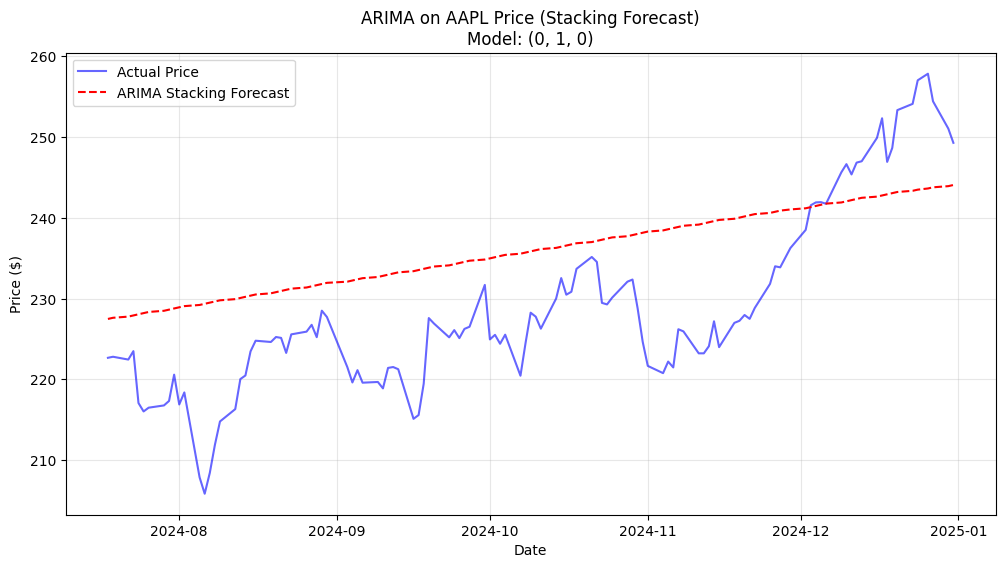

In [3]:
# 3. Prepare Data
ts_values = df[('Price', 'AAPL')].values
ts_dates = df.index

# 4. Train/Test Split
train_size = int(len(ts_values) * 0.9)
train, test = ts_values[:train_size], ts_values[train_size:]
test_dates = ts_dates[train_size:] # Keep dates separate for the plot

print(f"Training on {len(train)} points, Testing on {len(test)} points")

# 5. Fit ARIMA (on raw numbers)
model = auto_arima(train, seasonal=False, stepwise=True,
                   error_action='ignore', suppress_warnings=True)

print(f"Best Model: {model.order}")

# 6 & 7. STACKING FORECAST AND EVALUATION (The Flat Line)
print("Starting stacking forecast... (This demonstrates compounding error)")
forecast_horizon = len(test)
predictions = model.predict(n_periods=forecast_horizon)

mse = float(f"{mean_squared_error(test, predictions):.3g}")
print(f"Stacking ARIMA MSE: {mse}")

# 8. Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test, label="Actual Price", color='blue', alpha=0.6)
plt.plot(test_dates, predictions, label="ARIMA Stacking Forecast", color='red', linestyle='--')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.title(f"ARIMA on AAPL Price (Stacking Forecast)\nModel: {model.order}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training on 104 points, Testing on 12 points
Best Model: (0, 1, 0)
Starting stacking forecast... (This demonstrates compounding error)
Stacking ARIMA MSE: 68.1


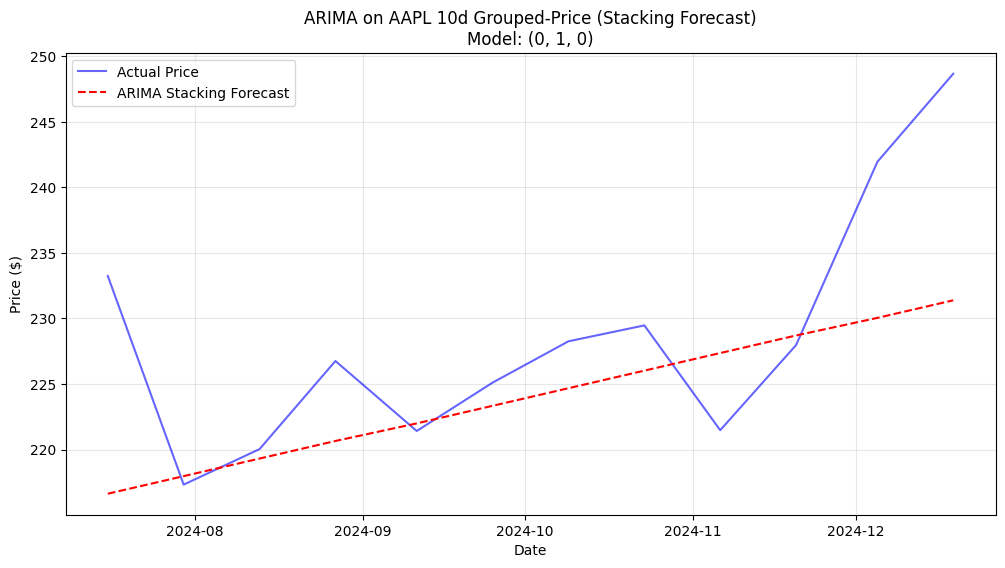

In [4]:
# 3. Prepare Data
ts_values = df[('Price', 'AAPL')].values[::10]
ts_dates = df.index[::10]

# 4. Train/Test Split
train_size = int(len(ts_values) * 0.9)
train, test = ts_values[:train_size], ts_values[train_size:]
test_dates = ts_dates[train_size:] # Keep dates separate for the plot

print(f"Training on {len(train)} points, Testing on {len(test)} points")

# 5. Fit ARIMA (on raw numbers)
model = auto_arima(train, seasonal=False, stepwise=True,
                   error_action='ignore', suppress_warnings=True)

print(f"Best Model: {model.order}")

# 6 & 7. STACKING FORECAST AND EVALUATION (The Flat Line)
print("Starting stacking forecast... (This demonstrates compounding error)")
forecast_horizon = len(test)
predictions = model.predict(n_periods=forecast_horizon)

mse = float(f"{mean_squared_error(test, predictions):.3g}")
print(f"Stacking ARIMA MSE: {mse}")

# 8. Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test, label="Actual Price", color='blue', alpha=0.6)
plt.plot(test_dates, predictions, label="ARIMA Stacking Forecast", color='red', linestyle='--')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.title(f"ARIMA on AAPL 10d Grouped-Price (Stacking Forecast)\nModel: {model.order}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training on 1042 points, Testing on 116 points
Best Model: (5, 1, 1)
Starting stacking forecast... (This demonstrates compounding error)
Stacking ARIMA MSE: 130.0


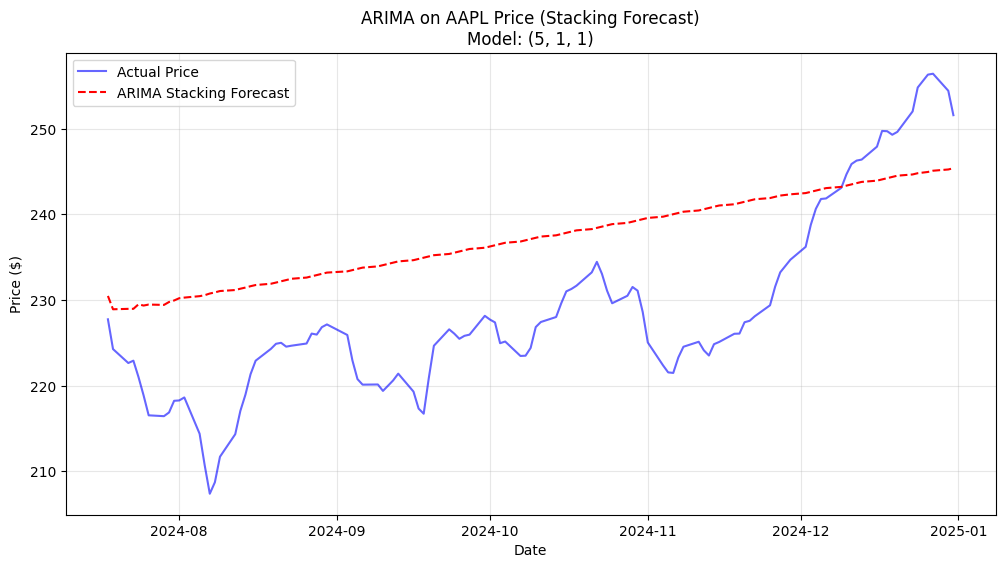

In [5]:
# 3. Prepare Data
ts_values = df[('Price_3', 'AAPL')].values
ts_dates = df.index

# 4. Train/Test Split
train_size = int(len(ts_values) * 0.9)
train, test = ts_values[:train_size], ts_values[train_size:]
test_dates = ts_dates[train_size:] # Keep dates separate for the plot

print(f"Training on {len(train)} points, Testing on {len(test)} points")

# 5. Fit ARIMA (on raw numbers)
model = auto_arima(train, seasonal=False, stepwise=True,
                   error_action='ignore', suppress_warnings=True)

print(f"Best Model: {model.order}")

# 6 & 7. STACKING FORECAST AND EVALUATION (The Flat Line)
print("Starting stacking forecast... (This demonstrates compounding error)")
forecast_horizon = len(test)
predictions = model.predict(n_periods=forecast_horizon)

mse = float(f"{mean_squared_error(test, predictions):.3g}")
print(f"Stacking ARIMA MSE: {mse}")

# 8. Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test, label="Actual Price", color='blue', alpha=0.6)
plt.plot(test_dates, predictions, label="ARIMA Stacking Forecast", color='red', linestyle='--')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.title(f"ARIMA on AAPL Price (Stacking Forecast)\nModel: {model.order}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training on 1042 points, Testing on 116 points
Best Model: (0, 1, 0)
Starting rolling forecast... (this creates the zigzag)
Stacking ARIMA MSE: 7.97


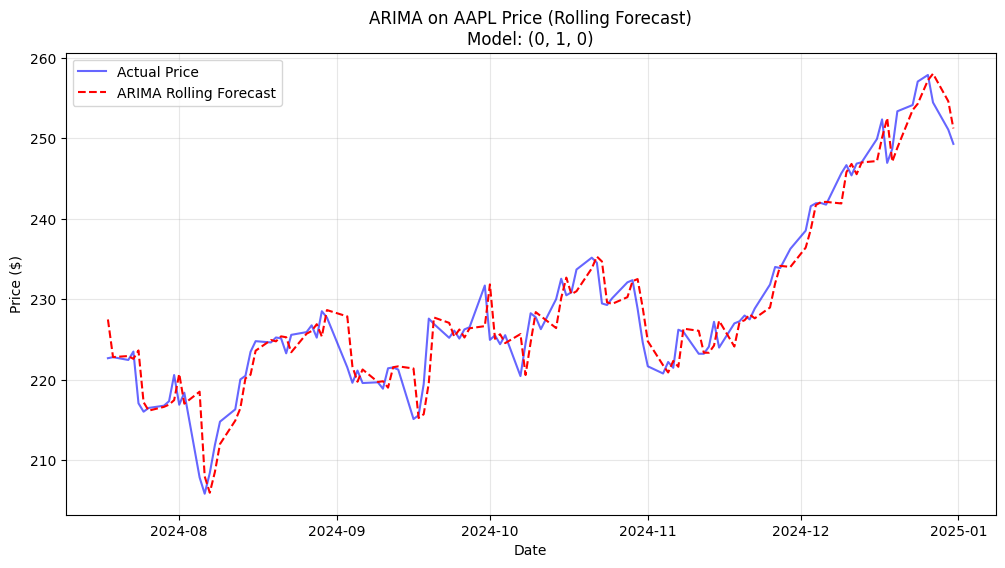

In [6]:
# 3. Prepare Data
ts_values = df[('Price', 'AAPL')].values
ts_dates = df.index

# 4. Train/Test Split
train_size = int(len(ts_values) * 0.9)
train, test = ts_values[:train_size], ts_values[train_size:]
test_dates = ts_dates[train_size:] # Keep dates separate for the plot

print(f"Training on {len(train)} points, Testing on {len(test)} points")

# 5. Fit ARIMA (on raw numbers)
model = auto_arima(train, seasonal=False, stepwise=True,
                   error_action='ignore', suppress_warnings=True)

print(f"Best Model: {model.order}")

# 6. ROLLING FORECAST
print("Starting rolling forecast... (this creates the zigzag)")
predictions = []

for i in range(len(test)):
    # Predict 1 step ahead
    # Since we used .values, this returns a numpy array. [0] works now.
    pred = model.predict(n_periods=1)[0]
    predictions.append(pred)

    # Update model with the REAL value from this step
    model.update([test[i]])

mse = float(f"{mean_squared_error(test, predictions):.3g}")
print(f"Stacking ARIMA MSE: {mse}")

# 8. Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test, label="Actual Price", color='blue', alpha=0.6)
plt.plot(test_dates, predictions, label="ARIMA Rolling Forecast", color='red', linestyle='--')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.title(f"ARIMA on AAPL Price (Rolling Forecast)\nModel: {model.order}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training on 1042 points, Testing on 116 points
Best Model: (5, 1, 1)
Starting rolling forecast... (this creates the zigzag)
Stacking ARIMA MSE: 1.23


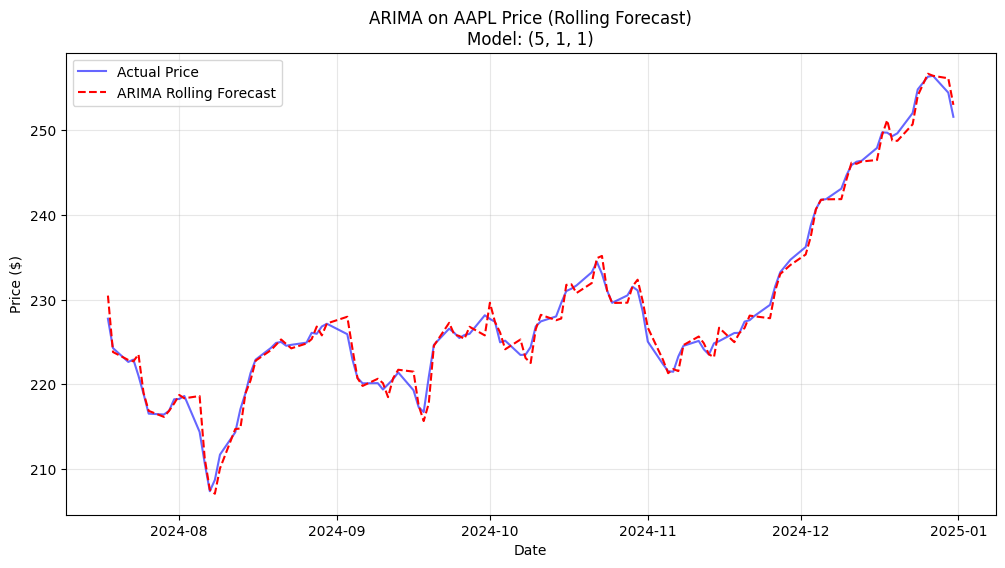

In [7]:
# 3. Prepare Data
ts_values = df[('Price_3', 'AAPL')].values
ts_dates = df.index

# 4. Train/Test Split
train_size = int(len(ts_values) * 0.9)
train, test = ts_values[:train_size], ts_values[train_size:]
test_dates = ts_dates[train_size:] # Keep dates separate for the plot

print(f"Training on {len(train)} points, Testing on {len(test)} points")

# 5. Fit ARIMA (on raw numbers)
model = auto_arima(train, seasonal=False, stepwise=True,
                   error_action='ignore', suppress_warnings=True)

print(f"Best Model: {model.order}")

# 6. ROLLING FORECAST
print("Starting rolling forecast... (this creates the zigzag)")
predictions = []

for i in range(len(test)):
    # Predict 1 step ahead
    # Since we used .values, this returns a numpy array. [0] works now.
    pred = model.predict(n_periods=1)[0]
    predictions.append(pred)

    # Update model with the REAL value from this step
    model.update([test[i]])

mse = float(f"{mean_squared_error(test, predictions):.3g}")
print(f"Stacking ARIMA MSE: {mse}")

# 8. Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test, label="Actual Price", color='blue', alpha=0.6)
plt.plot(test_dates, predictions, label="ARIMA Rolling Forecast", color='red', linestyle='--')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.title(f"ARIMA on AAPL Price (Rolling Forecast)\nModel: {model.order}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training on 1042 points, Testing on 116 points
Best Model: (0, 1, 0)
Starting stacking forecast... (This demonstrates compounding error)
Stacking ARIMA MSE (Scaled): 32.9


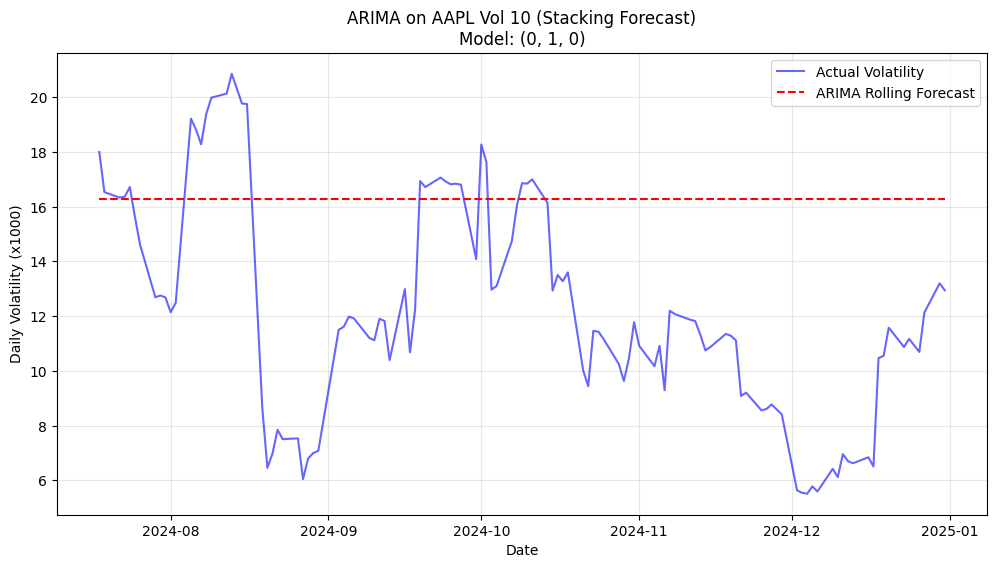

In [8]:
# 3. Prepare Data
ts_values = df[('Vol_10', 'AAPL')].values
ts_dates = df.index

# 4. Train/Test Split
train_size = int(len(ts_values) * 0.9)
train, test = ts_values[:train_size], ts_values[train_size:]
test_dates = ts_dates[train_size:] # Keep dates separate for the plot

print(f"Training on {len(train)} points, Testing on {len(test)} points")

# 5. Fit ARIMA (on raw numbers)
model = auto_arima(train, seasonal=False, stepwise=True,
                   error_action='ignore', suppress_warnings=True)

print(f"Best Model: {model.order}")

# 6 & 7. STACKING FORECAST AND EVALUATION (The Flat Line)
print("Starting stacking forecast... (This demonstrates compounding error)")
forecast_horizon = len(test)
predictions = model.predict(n_periods=forecast_horizon)

mse = round(mean_squared_error(test, predictions)*1000*1000, 1)
print(f"Stacking ARIMA MSE (Scaled): {mse}")

# 8. Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test * 1000, label="Actual Volatility", color='blue', alpha=0.6)
plt.plot(test_dates, [p * 1000 for p in predictions], label="ARIMA Rolling Forecast", color='red', linestyle='--')
plt.ylabel('Daily Volatility (x1000)')
plt.xlabel('Date')
plt.title(f"ARIMA on AAPL Vol 10 (Stacking Forecast)\nModel: {model.order}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training on 1042 points, Testing on 116 points
Best Model: (0, 1, 0)
Starting rolling forecast... (this creates the zigzag)
Stacking ARIMA MSE (Scaled): 3.3


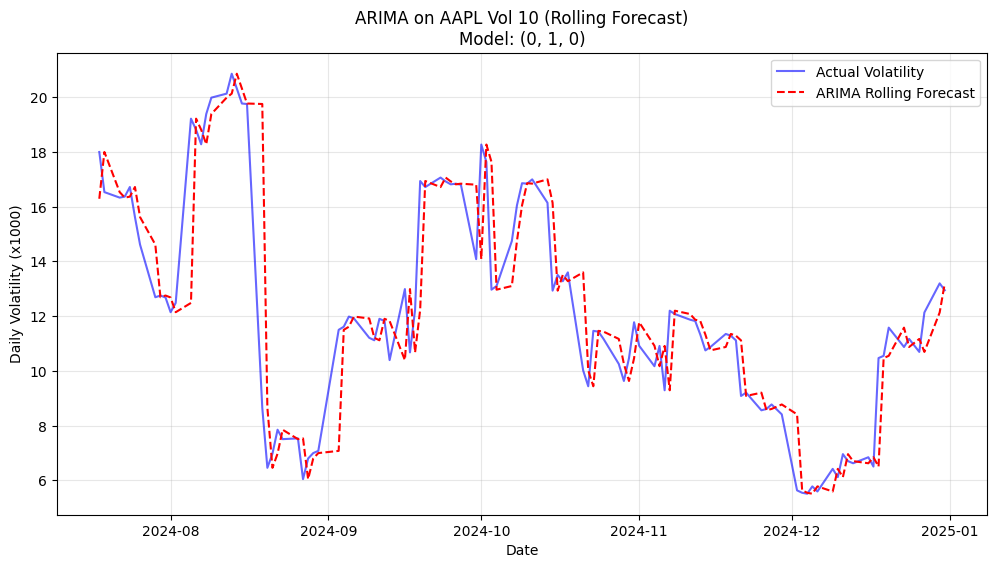

In [9]:
# 3. Prepare Data
ts_values = df[('Vol_10', 'AAPL')].values
ts_dates = df.index

# 4. Train/Test Split
train_size = int(len(ts_values) * 0.9)
train, test = ts_values[:train_size], ts_values[train_size:]
test_dates = ts_dates[train_size:] # Keep dates separate for the plot

print(f"Training on {len(train)} points, Testing on {len(test)} points")

# 5. Fit ARIMA (on raw numbers)
model = auto_arima(train, seasonal=False, stepwise=True,
                   error_action='ignore', suppress_warnings=True)

print(f"Best Model: {model.order}")

# 6. ROLLING FORECAST
print("Starting rolling forecast... (this creates the zigzag)")
predictions = []

for i in range(len(test)):
    # Predict 1 step ahead
    # Since we used .values, this returns a numpy array. [0] works now.
    pred = model.predict(n_periods=1)[0]
    predictions.append(pred)

    # Update model with the REAL value from this step
    model.update([test[i]])

mse = round(mean_squared_error(test, predictions)*1000*1000, 1)
print(f"Stacking ARIMA MSE (Scaled): {mse}")

# 8. Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test * 1000, label="Actual Volatility", color='blue', alpha=0.6)
plt.plot(test_dates, [p * 1000 for p in predictions], label="ARIMA Rolling Forecast", color='red', linestyle='--')
plt.ylabel('Daily Volatility (x1000)')
plt.xlabel('Date')
plt.title(f"ARIMA on AAPL Vol 10 (Rolling Forecast)\nModel: {model.order}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training on 1042 points, Testing on 116 points
Best Model: (5, 2, 4)
Starting rolling forecast... (this creates the zigzag)
Rolling ARIMA MSE: 0.0651


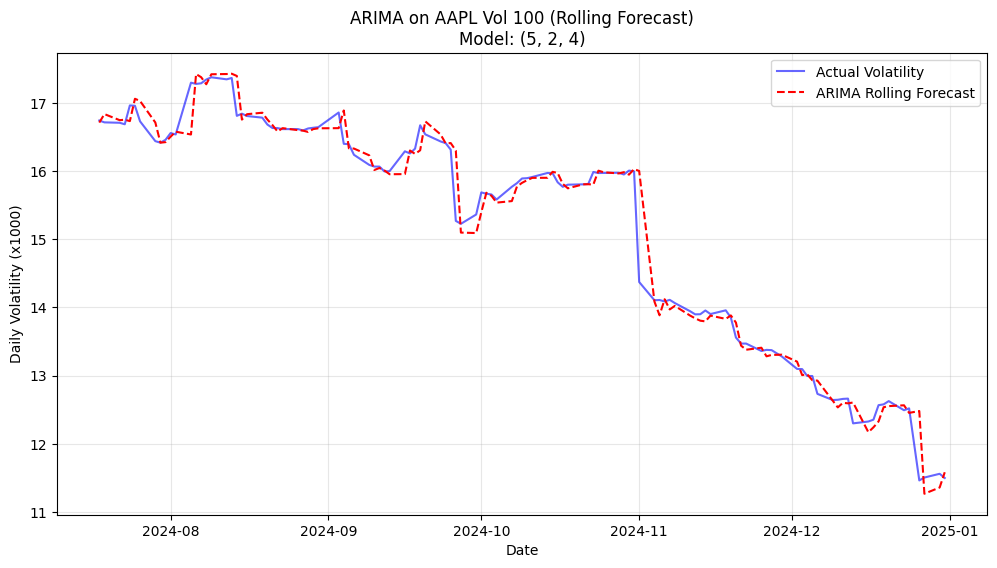

In [10]:
# 3. Prepare Data
# We create a separate variable for the Time Index for plotting later
# But we give the model PURE NUMPY ARRAYS (.values) to prevent the Key Error
ts_values = df[('Vol_100', 'AAPL')].values
ts_dates = df.index

# 4. Train/Test Split
train_size = int(len(ts_values) * 0.9)
train, test = ts_values[:train_size], ts_values[train_size:]
test_dates = ts_dates[train_size:] # Keep dates separate for the plot

print(f"Training on {len(train)} points, Testing on {len(test)} points")

# 5. Fit ARIMA (on raw numbers)
model = auto_arima(train, seasonal=False, stepwise=True,
                   error_action='ignore', suppress_warnings=True)

print(f"Best Model: {model.order}")

# 6. ROLLING FORECAST
print("Starting rolling forecast... (this creates the zigzag)")
predictions = []

for i in range(len(test)):
    # Predict 1 step ahead
    # Since we used .values, this returns a numpy array. [0] works now.
    pred = model.predict(n_periods=1)[0]
    predictions.append(pred)

    # Update model with the REAL value from this step
    model.update([test[i]])

# 7. Evaluate
mse = float(f"{mean_squared_error(test, predictions)*1000*1000:.3g}")
print(f"Rolling ARIMA MSE: {mse}")

# 8. Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test * 1000, label="Actual Volatility", color='blue', alpha=0.6)
plt.plot(test_dates, [p * 1000 for p in predictions], label="ARIMA Rolling Forecast", color='red', linestyle='--')
plt.ylabel('Daily Volatility (x1000)')
plt.xlabel('Date')
plt.title(f"ARIMA on AAPL Vol 100 (Rolling Forecast)\nModel: {model.order}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training on 1042 points, Testing on 116 points
Best Model: (5, 2, 4)
Starting stacking forecast... (This demonstrates compounding error)
Stacking ARIMA MSE (Scaled): 45.2


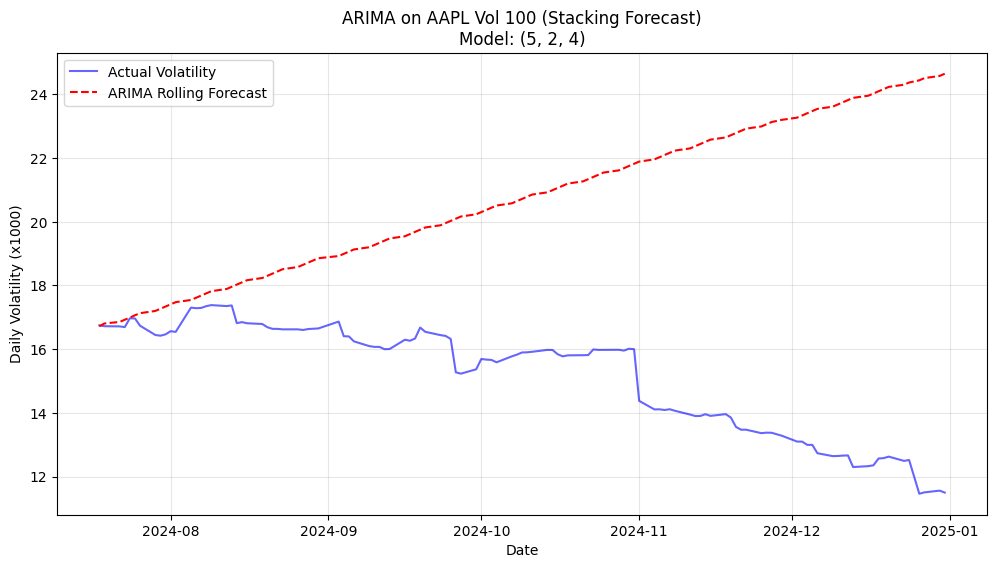

In [11]:
# 3. Prepare Data
# We create a separate variable for the Time Index for plotting later
# But we give the model PURE NUMPY ARRAYS (.values) to prevent the Key Error
ts_values = df[('Vol_100', 'AAPL')].values
ts_dates = df.index

# 4. Train/Test Split
train_size = int(len(ts_values) * 0.9)
train, test = ts_values[:train_size], ts_values[train_size:]
test_dates = ts_dates[train_size:] # Keep dates separate for the plot

print(f"Training on {len(train)} points, Testing on {len(test)} points")

# 5. Fit ARIMA (on raw numbers)
model = auto_arima(train, seasonal=False, stepwise=True,
                   error_action='ignore', suppress_warnings=True)

print(f"Best Model: {model.order}")

# 6 & 7. STACKING FORECAST AND EVALUATION (The Flat Line)
print("Starting stacking forecast... (This demonstrates compounding error)")
forecast_horizon = len(test)
predictions = model.predict(n_periods=forecast_horizon)

mse = round(mean_squared_error(test, predictions)*1000*1000, 1)
print(f"Stacking ARIMA MSE (Scaled): {mse}")

# 8. Plotting
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test * 1000, label="Actual Volatility", color='blue', alpha=0.6)
plt.plot(test_dates, [p * 1000 for p in predictions], label="ARIMA Rolling Forecast", color='red', linestyle='--')
plt.ylabel('Daily Volatility (x1000)')
plt.xlabel('Date')
plt.title(f"ARIMA on AAPL Vol 100 (Stacking Forecast)\nModel: {model.order}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

GB training rows: 1170, testing rows: 131
Gradient Boosting MSE on ARIMA-residuals (test): 0.5071709161089373


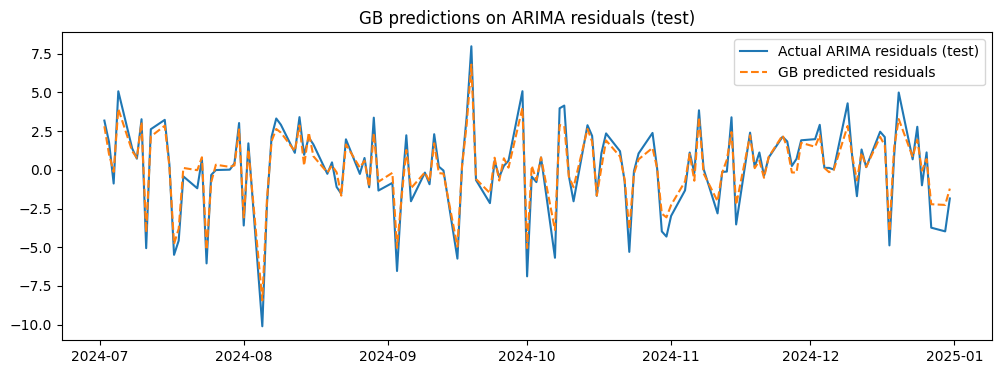

Top feature importances:
Return             0.939816
Price              0.048741
RSI                0.005521
lag_ets_resid_1    0.001728
lag_ets_resid_2    0.001362
lag_ets_resid_3    0.001088
MACD               0.000874
Signal             0.000870
arima_pred_lag1    0.000000
dtype: float64


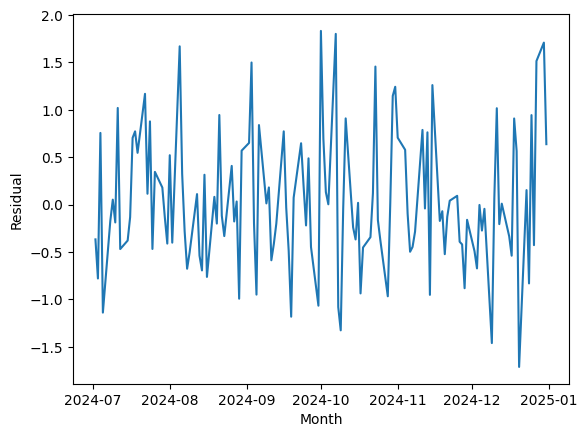

In [47]:
# ------------------------------
# 3a. Gradient Boosting on ARIMA residuals
# ------------------------------
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Variables from previous steps are not explicitly defined in this cell's scope.
# We assume 'model' refers to the auto_arima model and 'predictions' to its forecast.

# Define auto_model and forecast from the most recently executed ARIMA model
# NOTE: The last ARIMA model (variable 'model') was fitted on 'Vol_100', not 'Price' or ETS residuals of 'Price'.
# This makes the ARIMA component inconsistent with a price forecasting ensemble.
auto_model = model
forecast = predictions

# Ensure forecast does not contain NaNs, replace with 0 if it does
if np.isnan(forecast).any():
    print("WARNING: ARIMA forecast contains NaNs. Filling with zeros for Gradient Boosting.")
    forecast = np.nan_to_num(forecast, nan=0.0) # Fill NaNs with 0

#a. Residuals
#ai. Take the residuals from the ETS model fitted in the previous step
# residuals_series = pd.Series(residuals, index=df.index, name='ets_residuals') # Original placeholder line
residuals_series = df['Price'] - fitted_ets_series # Corrected to use actual ETS residuals
residuals_series.name = 'ets_residuals'

arima_in_sample = pd.Series(auto_model.predict_in_sample(), index=df.index[:train_size])
arima_pred_series = pd.Series(index=df.index, dtype='float64', name='arima_pred')
arima_pred_series.iloc[:train_size] = arima_in_sample
arima_pred_series.iloc[train_size:train_size + len(forecast)] = np.asarray(forecast)

#aii. compute ARIMA residuals (target for GB)
# This is now ETS residuals MINUS ARIMA predictions (which are based on Vol_100, if not re-trained)
arima_residuals = residuals_series - arima_pred_series
arima_residuals.name = 'arima_residuals'

#b. Features
#bi. Make new pd for features
features = pd.DataFrame(index=df.index)
features['MACD'] = df['MACD']
features['Signal'] = df['Signal']
features['RSI'] = df['RSI']
features['Price'] = df['Price']
features['Return'] = df['Price'].pct_change()

#bii. Add lagged ETS residuals (only past values as predictors)
n_lags = 3
for lag in range(1, n_lags + 1):
    features[f'lag_ets_resid_{lag}'] = residuals_series.shift(lag)

features['arima_pred_lag1'] = arima_pred_series.shift(1)

#biii. Keep testing/training data the same time boundary as ETS/ARIMA
df_gb = pd.concat([features, arima_residuals], axis=1).dropna()
gb_index = df_gb.index
train_last_idx = df.index[train_size - 1]
train_mask = gb_index <= train_last_idx
test_mask = gb_index > train_last_idx
X = df_gb.drop(columns=['arima_residuals'])
y = df_gb['arima_residuals']
X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]
print(f"GB training rows: {len(X_train)}, testing rows: {len(X_test)}")

#c. Train
gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train)

#d. Evaluate
y_pred = gb.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred)
print("Gradient Boosting MSE on ARIMA-residuals (test):", mse_gb)

#e. Plot
#ei. Plot actual vs predicted ARIMA-residuals on test
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test.values, label='Actual ARIMA residuals (test)')
plt.plot(y_test.index, y_pred, linestyle='--', label='GB predicted residuals')
plt.legend()
plt.title("GB predictions on ARIMA residuals (test)")
plt.show()

#eii. Plot differences
y_errors = pd.Series(y_pred, index=y_test.index) - y_test
plt.plot(y_test.index, y_errors, label='Prediction error')
plt.xlabel("Month")
plt.ylabel("Residual")

#eiii. Feature importances
fi = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top feature importances:")
print(fi.head(10))

Combined model (ETS + ARIMA + GB) MSE on price (test timestamps): 0.5073951380492953


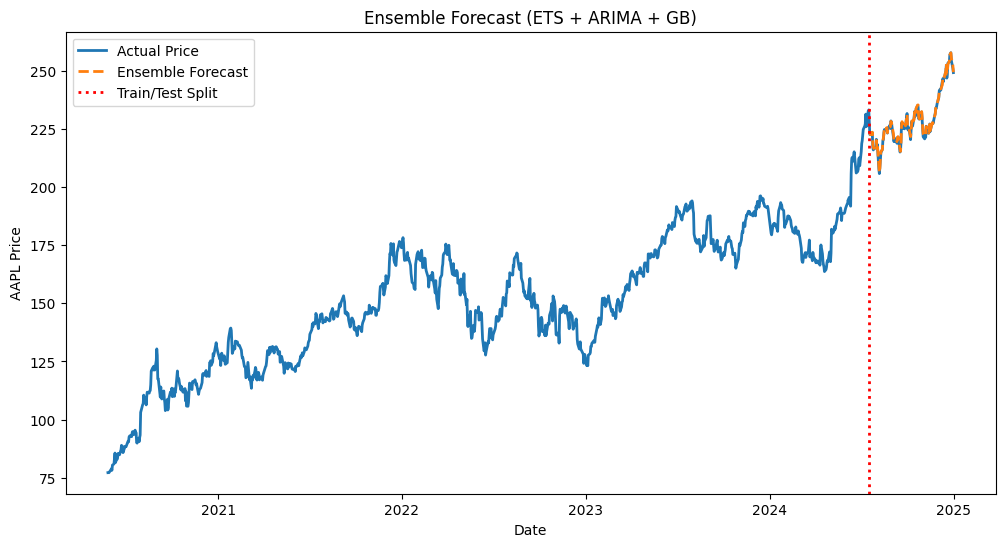

In [19]:
import pandas as pd

#Ensemble of ETS + ARIMA + GB for estimate of 'current future' prices.

#f. Evaluate ETS + ARIMA + GB
fitted_ets_series = pd.Series(ets_fit.fittedvalues, index=df.index, name='ets_fitted') # Corrected to use ets_fit
gb_correction = pd.Series(y_pred, index=X_test.index, name='gb_correction')
combined_pred = fitted_ets_series.loc[X_test.index] + arima_pred_series.loc[X_test.index] + gb_correction
true_price_test = df['Price'].loc[X_test.index]
combined_mse = mean_squared_error(true_price_test, combined_pred)
print("Combined model (ETS + ARIMA + GB) MSE on price (test timestamps):", combined_mse)

# Define split_date for plotting
split_date = df.index[train_size - 1]

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Price'], label='Actual Price', linewidth=2)
plt.plot(combined_pred.index, combined_pred.values, label='Ensemble Forecast', linestyle='--', linewidth=2)

# Add vertical line at split
plt.axvline(x=split_date, color='red', linestyle=':', linewidth=2, label='Train/Test Split')

plt.xlabel("Date")
plt.ylabel("AAPL Price")
plt.title("Ensemble Forecast (ETS + ARIMA + GB)")
plt.legend()
plt.show()

In [46]:
# 3b. Fit ARIMA on ETS residuals
# We need train_size from previous steps. Re-calculate if needed, or ensure it's in scope.
# The residuals_series is defined in hA8lcCEowZ5F as df[('Price', 'AAPL')] - fitted_ets_series

# Ensure residuals_series and train_size are defined
# (These would be defined after running AIYFKJy3rODD and cell_ets_model, then hA8lcCEowZ5F partial execution)

# Recalculate train_size to ensure it's fresh if previous cells were not fully run
train_size = int(len(df['Price']) * 0.9)

# If residuals_series is not yet calculated from ETS, create a placeholder for auto_arima
# (This situation ideally should not happen if previous cells are run in order)
# For robustness, we will assume residuals_series comes from hA8lcCEowZ5F

# We need to make sure the residuals used for ARIMA are only from the training period
arima_train_residuals = residuals_series.iloc[:train_size].dropna()

print(f"Training ARIMA on {len(arima_train_residuals)} residuals from ETS model...")

# 5. Fit ARIMA on ETS residuals
model = auto_arima(arima_train_residuals, seasonal=False, stepwise=True,
                   error_action='ignore', suppress_warnings=True)

print(f"Best ARIMA Model for ETS Residuals: {model.order}")

# Generate predictions for the test set of residuals
forecast_horizon = len(df['Price'][train_size:]) # Length of the test set
predictions = model.predict(n_periods=forecast_horizon)

# Convert predictions to a pandas Series for easier handling, with appropriate index
# The index should align with the test portion of the df
predictions = pd.Series(predictions, index=df['Price'].index[train_size:])

print("ARIMA model for ETS residuals fitted and predictions generated.")

Training ARIMA on 1173 residuals from ETS model...
Best ARIMA Model for ETS Residuals: (0, 0, 0)
ARIMA model for ETS residuals fitted and predictions generated.


In [45]:
import statsmodels.tsa.api as sm
import pandas as pd # Ensure pandas is imported as it's needed for Series

# 3a. Fit ETS Model (for Price)
# Assuming 'Price' is the target for the ensemble
ets_ts_values = df['Price'] # NaNs handled by ffill in AIYFKJy3rODD and already dropped by df.dropna()
# Use freq argument in model constructor to specify frequency
ets_model = sm.ExponentialSmoothing(ets_ts_values, seasonal_periods=30, trend='add', seasonal='add', initialization_method="estimated", freq='B')
ets_fit = ets_model.fit()

# Get in-sample fitted values
fitted_ets_series = pd.Series(ets_fit.fittedvalues, index=ets_ts_values.index, name='ets_fitted')

# Calculate ETS residuals
residuals_series = ets_ts_values - fitted_ets_series
residuals_series.name = 'ets_residuals'

print("ETS Model fitted, in-sample predictions (fitted_ets_series), and residuals_series created.")

ETS Model fitted, in-sample predictions (fitted_ets_series), and residuals_series created.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE : 802.9421716449754
RMSE: 28.336234253072078
MAE : 21.692307772628705


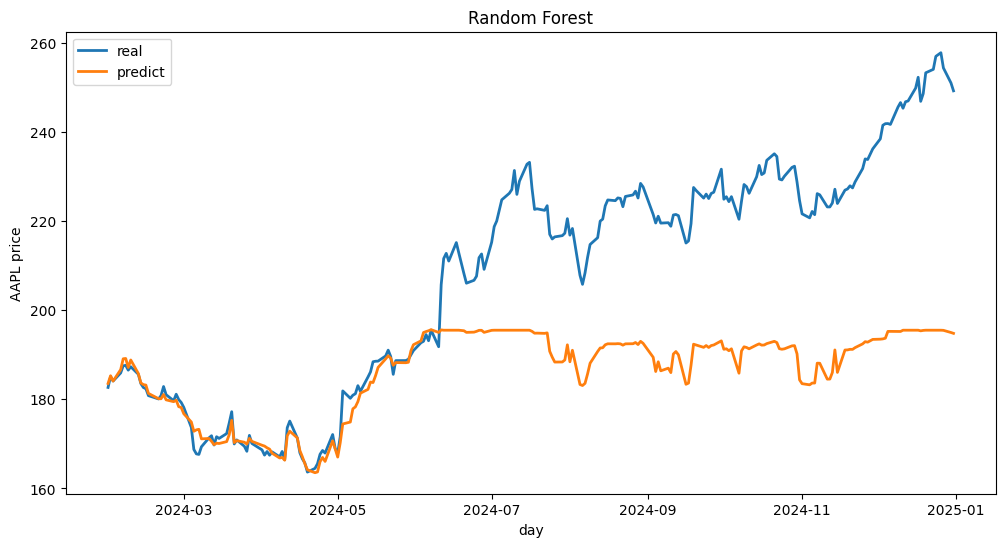

In [23]:
#3b. Random forest

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

X = df[['RSI', 'MACD', 'Signal', 'EMA_26', 'EMA_12']]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

rf = RandomForestRegressor(
    n_estimators=1024,
    max_depth=None,
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='real', linewidth=2)
plt.plot(y_test.index, y_pred, label='predict', linewidth=2)
plt.xlabel("day")
plt.ylabel("AAPL price")
plt.title("Random Forest")
plt.legend()
plt.show()